In questo secondo notebook andremo a fare un finetuning su un dataset contenente degli sketch disegnati, per provare ad avere una differenza di accuracy più sostanziale. \
I seguenti passi, simili al precedente notebook, saranno valutare l'acuracy sul modello CLIP con zero shot, per poi utilizzare il metodo LoRA per il finetuning e verificare la accuracy finale.

In [70]:
from datasets import load_dataset
from datasets import Dataset
from transformers import CLIPProcessor, CLIPModel
from transformers import CLIPForImageClassification, AutoImageProcessor, CLIPConfig
from peft import get_peft_model, LoraConfig, TaskType
from transformers import TrainingArguments, Trainer
from transformers import DefaultDataCollator
import numpy as np
import evaluate
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import os
from PIL import Image
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


In [56]:
selected_classes = [
    "cat", "dog", "airplane", "apple", "bicycle",
    "tree", "house", "car", "clock", "umbrella"
]
#Caricamento del dataset
def load_quickdraw(class_name, path ="./data/quickdraw_data", n_samples = 500):
    data = np.load(os.path.join(path, f"{class_name}.npy"))
    data = data[:n_samples]
    images = []
    for img_arr in data:
        img = Image.fromarray(img_arr.reshape(28, 28)).convert("RGB")
        img = img.resize((224, 224))
        images.append({"image": img, "text": f"a drawing of a {class_name}", "label": class_name})
    return images

#Costruiamo il dataset con le 10 classi selezionate
dataset = []
for cls in selected_classes:
    class_data = load_quickdraw(cls)
    dataset.extend(class_data)

#Impostiamo gli indici della classe
label2id = {label: idx for idx, label in enumerate(selected_classes)}
id2label = {i: label for i, label in enumerate(selected_classes)}
for item in dataset:
    item["label_id"] = label2id[item["label"]]

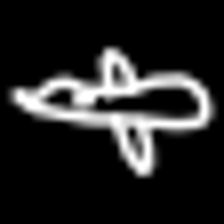

Label: airplane


{'image': <PIL.Image.Image image mode=RGB size=224x224>,
 'text': 'a drawing of a airplane',
 'label': 'airplane',
 'label_id': 2}

In [29]:
id = 1024
display(dataset[id]["image"])
print(f"Label: {dataset[id]["label"]}")

dataset[id]

In [51]:
#Vediamo la zero shot 
model_id = "openai/clip-vit-base-patch16"
modelbase = CLIPModel.from_pretrained(model_id)
processorbase = CLIPProcessor.from_pretrained(model_id)

In [35]:
#Creiamo due split uno per il training nel finetuning e uno per il validation
ds_train , ds_val = train_test_split(dataset, test_size = 0.1, stratify=[d["label_id"]for d in dataset])

#Convertiamo per compatibilità con HF
train_dataset = Dataset.from_list(ds_train)
eval_dataset = Dataset.from_list(ds_val)

In [36]:
#Funzione di preprocess e mapping 
def preprocess(examples):
    encoding = processor(
        text=examples["text"],
        images=examples["image"],
        return_tensors="pt",
        padding=True
    )
    return {
        "pixel_values": encoding["pixel_values"][0],  # 3 224 224
        "input_ids": encoding["input_ids"][0],
        "attention_mask": encoding["attention_mask"][0],
        "labels": examples["label_id"]
    }

train_dataset = train_dataset.map(preprocess)
eval_dataset = eval_dataset.map(preprocess)

Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [47]:
train_dataset2 = train_dataset.remove_columns([col for col in train_dataset.column_names if col not in ['pixel_values', 'input_ids', 'attention_mask', 'labels']])
eval_dataset2 = eval_dataset.remove_columns([col for col in eval_dataset.column_names if col not in ['pixel_values', 'input_ids', 'attention_mask', 'labels']])


In [52]:
#Facciamo zero shot su CLIP
text = [f"a drawing of a {label}" for label in selected_classes]
device = "cuda" if torch.cuda.is_available else "cpu"
modelbase.eval()
modelbase.to(device)

with torch.no_grad():
    text_inputs = processorbase(text=text, return_tensors="pt", padding=True).to(device)
    text_embeddings = modelbase.get_text_features(**text_inputs)
    text_embeddings = text_embeddings / text_embeddings.norm(p=2, dim=-1, keepdim=True)

correct = 0
total = 0

for sample in tqdm(eval_dataset):
    image = sample["image"]
    true_label_id = sample["label_id"]

    
    image_input = processorbase(images=image, return_tensors="pt").to(device)
    
    with torch.no_grad():
        image_features = modelbase.get_image_features(**image_input)
        image_features = image_features / image_features.norm(p=2, dim=-1, keepdim=True)

        # Similarità con ogni testo
        logits = image_features @ text_embeddings.T  # (1, 10)
        pred_class = logits.argmax(dim=-1).item()
        
        if pred_class == true_label_id:
            correct += 1
        total += 1

accuracy = correct / total
print(f"Zero-shot accuracy on QuickDraw test set (10 classes): {accuracy:.4f}")

100%|█████████████████████████████████████████| 500/500 [00:25<00:00, 19.38it/s]

Zero-shot accuracy on QuickDraw test set (10 classes): 0.7500


In [57]:
#Carichiamo il modello CLIP per applicarci LoRA
model_id = "openai/clip-vit-base-patch16"

config = CLIPConfig.from_pretrained(model_id,
                                    num_labels=len(label2id),
                                    label2id=label2id, id2label=id2label)
model = CLIPForImageClassification.from_pretrained(
    model_id,
    config=config,
    ignore_mismatched_sizes=True  # adattare la testa di classificazione a 10 classi
)

processor = AutoImageProcessor.from_pretrained(model_id)

Some weights of CLIPForImageClassification were not initialized from the model checkpoint at openai/clip-vit-base-patch16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [58]:
#Applichiamo LoRA al modello e faccio il finetuning
peft_config = LoraConfig(
    task_type = None,
    target_modules=["q_proj", "v_proj"], #Matrici della self attention
    inference_mode = False,
    r = 8, #Rango delle matrici
    lora_alpha = 16, #Scaling per stabilizzare la train loss
    lora_dropout = 0.01,
    bias = 'none',
    modules_to_save = ["classifier"]
)

#Apllichiamo LoRA al modello CLIP
lora_model = get_peft_model(model, peft_config)


#Verifichiamo i parametri addestrabili del nuovo modello e notiamo che sono nettamente meno
lora_model.print_trainable_parameters()

trainable params: 302,602 || all params: 86,109,716 || trainable%: 0.3514


In [66]:
#Configurazione dell'addestramento

training_args = TrainingArguments(
    output_dir='./results',
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    use_cpu = False,
    eval_strategy='epoch',
    do_eval = True,
    save_strategy='epoch',
    logging_strategy="epoch",
    report_to = "wandb",
    run_name="clip-lora-quicksketch",
    remove_unused_columns=False,
    label_names=["labels"],
    logging_steps=10,
    metric_for_best_model="accuracy",
    fp16=True, #per GPU
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)

    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [71]:


class ImageClassificationDataCollator(DefaultDataCollator):
    def __call__(self, features):
        # Rimuovi 'input_ids' e non necessari
        for f in features:
            f.pop("input_ids", None)
            f.pop("attention_mask", None)
        return super().__call__(features)

data_collator = ImageClassificationDataCollator()

trainer = Trainer(
    model=model.to(device),
    args=training_args,
    train_dataset=train_dataset2,
    eval_dataset=eval_dataset2,
    tokenizer=processor,
    data_collator = data_collator,
    compute_metrics=compute_metrics
)
trainer.train()

/tmp/ipykernel_6037/2372148870.py:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.982400,1.826500,0.726000,0.727075,0.726000,0.701520
2,1.710000,1.590500,0.732000,0.758643,0.732000,0.695043
3,1.530000,1.497000,0.734000,0.771554,0.734000,0.698580


TrainOutput(global_step=213, training_loss=1.7408218383789062, metrics={'train_runtime': 981.991, 'train_samples_per_second': 13.748, 'train_steps_per_second': 0.217, 'total_flos': 1.04807107270656e+18, 'train_loss': 1.7408218383789062, 'epoch': 3.0})